<a href="https://colab.research.google.com/github/menouarazib/llm/blob/main/RAG_pipeline_with_Zephyr_7b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating a Chatbot with zephyr-7b-beta and RAG**

In this notebook, we will create a chatbot based on [zephyr-7b-beta](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta). This chatbot will be augmented with domain-specific factual information (data from website) using RAG, or Retrieval Augmented Generation. RAG is a technique that combines a large language model with a document retrieval system to generate answers that are grounded on factual sources.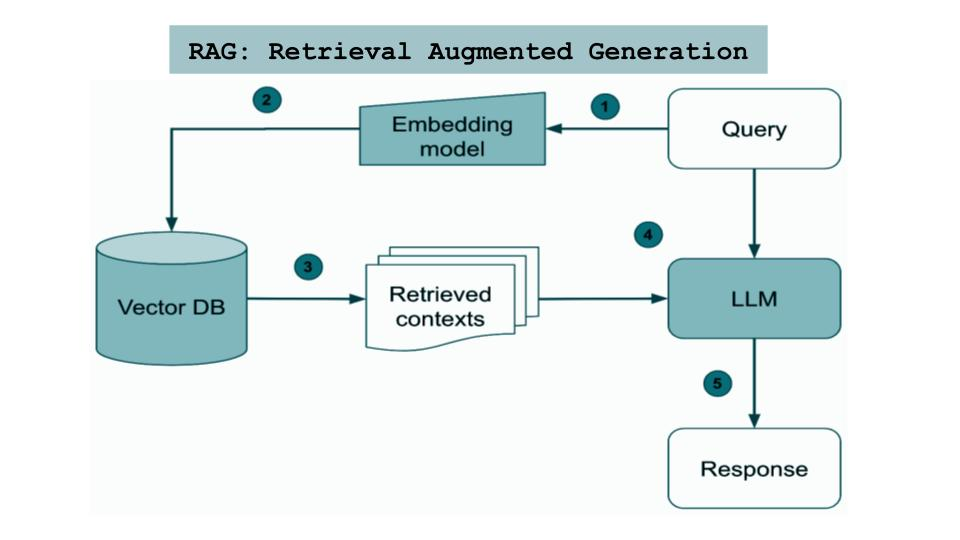

## **1. Setup development environment**

In [21]:
# 'langchain' is a tool for building language model applications.
# It provides the building blocks needed to create chains and agents.
!pip install -q langchain

# 'faiss-cpu' is a library for efficient similarity search and clustering of dense vectors.
!pip install -q faiss-cpu

## **2. Load External Data**

In [22]:
# The 'nest_asyncio' package is used to overcome a limitation in Python's 'asyncio' library. By design, 'asyncio' does not allow its event loop to be nested[^1^][1]. This can present a practical problem: when in an environment where the event loop is already running, it's impossible to run tasks and wait for the result. Trying to do so will give the error "RuntimeError: This event loop is already running".

# The 'nest_asyncio.apply()' function patches 'asyncio' to allow nested use of 'asyncio.run' and 'loop.run_until_complete'. This can be particularly useful in environments such as web servers, GUI applications, and Jupyter notebooks, where the event loop may already be running.

# To use the 'nest_asyncio' package, first import it
import nest_asyncio

# Then apply the patch to the current event loop, or optionally specify a different loop as an argument
nest_asyncio.apply()

In [23]:
from langchain.document_loaders import WebBaseLoader

# Load website pages
loader = WebBaseLoader(["https://arxiv.org/html/2402.03620v1"])
# To bypass SSL verification errors during fetching, you can set the “verify” option:
loader.requests_kwargs = {'verify': False}
documents = loader.load()
print(documents)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'arxiv.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[Document(page_content='\n\n\n\nSelf-Discover: Large Language Models Self-Compose Reasoning Structures\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n1 Introduction\n\n2 Self-Discovering Reasoning Structures for Problem-Solving\n\n\n2.1 Stage 1: Self-Discover Task-Specific Structures\n\nSELECT\nADAPT\nIMPLEMENT\n\n\n2.2 Stage 2: Tackle Tasks Using Discovered Structures\n\n\n\n3 Experiment Setup\n\n3.1 Tasks\n3.2 Models\n3.3 Baselines\n\n\n\n4 Results\n\n4.1 Does Self-DiscoverÂ\xa0Improve LLM Reasoning?\n4.2 Which Types of Problems Do Self-DiscoverÂ\xa0Help the Most?\n4.3 How Efficient is Self-Discover?\n4.4 Qualitative Examples\n\n\n\n5 Deep Diving Into Self-Discovered Reasoning Structures\n\n5.1 Importance of Self-DiscoverÂ\xa0Actions\n\n5.2 Towards Universality of Discovered Reasoning Structures\n\nApplying PaLM 2-L Discovered Structures to GPT-4\nApplying GPT-4 Discovered Structures to Llama2 and ChatGPT\n\n\n\n\n\n6 Related Work\n\n6.1 Prompting Methods\n6.2 Reasoning and Planning\n\n\n7 Conclusio

## **3. Text Chunking Using Recursive Character Splitter**

In [24]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Split documents
splitter = RecursiveCharacterTextSplitter()
documents = splitter.split_documents(documents)

## **4. Generating Embeddings**

In [25]:
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings
from google.colab import userdata
from langchain.vectorstores import Chroma

# Retrieve the HuggingFace API token stored in Google Colab Secrets
hugging_face_token = userdata.get('HF_TOKEN')

embeddings_model = HuggingFaceInferenceAPIEmbeddings(
    api_key=hugging_face_token,
    model_name="BAAI/bge-base-en-v1.5"
)

In [26]:
from langchain.vectorstores import FAISS

vectorstore = FAISS.from_documents(documents, embedding=embeddings_model)
# Create retriever
retriever = vectorstore.as_retriever()

In [27]:
from langchain_core.prompts import ChatPromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [28]:
from langchain.llms import HuggingFaceHub

llm = HuggingFaceHub(
    repo_id="huggingfaceh4/zephyr-7b-beta",
    model_kwargs={"temperature": 0.1, "max_length": 60,"max_new_tokens":128},
    huggingfacehub_api_token=hugging_face_token
)

In [29]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# Create RAG chain
rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [30]:
# Now you can use rag_chain to answer questions based on the web page content
response = rag_chain.invoke("What is the Self-Discover: Large Language Models Self-Compose Reasoning Structures?")
response = response.split("Question:")
print(f"Question:{response[-1]}")


Question: What is the Self-Discover: Large Language Models Self-Compose Reasoning Structures?

Answer: Self-Discover is a framework introduced in the paper "Self-Discover: Large Language Models Self-Compose Reasoning Structures" published in arXiv in 2023. The framework allows LLMs to self-discover a reasoning structure for any task from a seed set of general problem-solving skills without the need for task labels or training. The framework consists of two stages: Stage 1, where LLMs select, adapt, and implement an actionable reasoning structure, and Stage 2, where LLMs follow the discovered reasoning structure to solve every instance of the
